# Сравнение трудоёмкости алгоритмов поисков на графах

* DFS - Depth-First Search - Поиск в глубину
* BFS - Breadth-First Search - Поиск в ширину

https://arxiv.org/abs/2111.07345

Другими словами, измерение безразмерной величины $\cfrac{\Theta_{DFS}}{\Theta_{BFS}} = \Large\psi$

> В качестве среды разработки используем интерактивные блокноты [Jupyter<base target="_blank">](https://jupyter.org/), код написан на языке [Julia <base target="_blank">](https://julialang.org/) и выполнен паралленьно на 20 ядрах процессора.

## Что будем делать?

Генерация случайного графа оказалась нетривиальной задачей. Чтобы как-то ограничить исследование, предлагаю следующие шаги:
1. Разобраться с инструментами;
1. Чётко формализовать алгоритм генерации графа;
2. Провести ряд вычислительных экспериментов, используя разные алгоритмы генерации с построением графиков зависимостей.

>### Отступление
>Человек ленив. Там, где можно немного упростить себе жизнь, это будет сделано. С этой целью было создано множество высокоуровневых языков программирования, Julia - один из таких. В её экосистеме написано множество библиотек, где описываются графы и вводятся распространённые алгоритмы на них.
>
>Человек ленив, а студент - тоже человек. Чем писать с нуля известные структуры (с риском ошибиться на ерунде), предлагаю сразу перейти к непосредственно поставленной задаче, доверившись, на этот раз, разработчикам используемых здесь библиотек.
---
## 0. Поиски
Сначала напишем сами алгоритмы поиска в ширину и глубину. По сути своей, это один и тот же алгоритм, реализованный на двух разных структурах данных: **стек** для поиска в глубину и **очередь** для поиска в ширину. И то и другое нам отлично заменит стандартный Vector:

In [4]:
function findpath(p!, graph, a, b)
    adj_list = graph.fadjlist    # Вызов у объекта граф поля со списком смежности
    visited = falses(length(adj_list))
    parent = fill(-1, length(adj_list))
    dataStructure = Int64[]
    push!(dataStructure, a)
    visited[a] = true
    while !isempty(dataStructure)
        curr_node = p!(dataStructure)        # Вот здесь вся разница!
        for neighbor in adj_list[curr_node]
            if !visited[neighbor]
                visited[neighbor] = true
                parent[neighbor] = curr_node
                push!(dataStructure, neighbor)
            end
        end
        if curr_node == b
            path = [b]
            while path[end] != a
                push!(path, parent[path[end]])
            end
            return reverse(path)
        end
    end
    return Int64[]
end

# Подставляя в 9-ю строчку выше соответствующую функцию
# удаления последнего или первого элемента добиваемся желаемого
dfs(graph, a, b) = findpath(pop!,      graph, a, b) 
bfs(graph, a, b) = findpath(popfirst!, graph, a, b);

Примечание: в ячейке выше используются два эквивалентных синтаксиса задания функции.

## 1. Инструменты
Ниже приведены библиотеки языка Julia, которые нам понадобятся в процессе работы:
* Библиотека для генерации различных графов
* Библиотеки рисования схем графов и графиков для отрисовки статистики

In [11]:
using Graphs
using GraphPlot
using Colors
# using Compose
using Plots
using PlotThemes
# using OnlineStats
# using GraphRecipes
# using BenchmarkTools
using LaTeXStrings;

### Небольшой пример
Простенький демонстрационный граф, который предоставляет сама библиотека 

In [49]:
# Обернём библиотечную функцию для упрощения дальшейших вызовов:
function plot_graph(graph)
    # Все аргументы рисовалки более-менее самообъясняющие:
    gplot(   
        graph,
        nodefillc = "black",
        nodelabel = 1:nv(graph),
        nodelabelc = "white",
        edgestrokec = "darkgray",
    )
end;

plot_graph (generic function with 1 method)

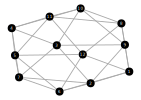

In [57]:
# Здесь `:icosahedral` это значение-лейбл, служащее аргументом функции отрисовки
sample = smallgraph(:icosahedral)

plot_graph(sample)

In [58]:
dfs(sample, 1, 10)

4-element Vector{Int64}:
  1
 12
 11
 10

In [59]:
bfs(sample, 1, 10)

3-element Vector{Int64}:
  1
  8
 10

### Алгоритм расчёта трудоёмкости
На графе из примера покажем, как будем считать трудоёмкость алгоритмов. В используемой библиотеке это удобно делать следующим образом:
1. У `sample_12` выберем вершину (у нас вершины имеют уникальные номера);
2. Начиная с неё с помощью библиотечных функций построим орграфы, основанные на интересующих нас алгоритмах обхода;
3. Найдём геодезические расстояния до всех вершин - они вернутся в виде массива (вектора);
4. По индексу найдём в нём расстояние до интересующей нас вершины.

In [461]:
@inline function countGoodInRadiusAndAllBad(distances, radius)
    if radius == typemax(radius)
        return (0, length(distances) - 1)
    end
    inradius = bad = 0
    bound = typemax(radius)
    @simd for distance in distances
        inradius += 0<distance<radius
        bad  += distance == bound
    end
    return (inradius, bad)
end


function alldists_from_node(graph, alg)
    nodes = nv(graph)
    meandists = zeros(nodes)
    
    Threads.@threasd for node_from in 1:nodes
        orgraph = alg(graph, node_from)
        gdists = gdistances(orgraph, node_from)
        
        inradius = bad = 0
        
        for gd in gdists
            inradius, bad += countGoodInRadiusAndAllBad(gdists, gd)
        end

        totalpaths = nodes-1-bad
        if totalpaths == 0
            continue
        end
        meandists[node_from] = inradius/totalpaths
    end
    return mean(meandists)
end

ψ(g) = alldists_from_node(g, dfs_tree) / alldists_from_node(g, bfs_tree);

In [ ]:
ψ(uniform_tree(600))
alldists_from_node(binary_tree(20), bfs_tree)

In [196]:
 Base.:+(t1::Tuple{Int64, Int64}, t2::Tuple{Int64, Int64}) = t1[1] + t2[1], t1[2] + t2[2]

In [54]:
nothing

>Отлично, теперь мы готовы составить процедуру сравнения двух алгоритмов. Замечу, что если выбранная вершина принадлежит другой компоненте связности, то `gdistances` вернёт наибольшее число типа `Int64`

...сначала написал я и реализовал довольно прямолинейную однопоточную функцию. Однако дальше с ростом размеров входных графов потребовалось *немного* её соптимизировать и этот процесс затянулся на два дня. Были перепробованы различные многопоточные реализации, без прибегания к совсем уж неочевидным не знакомому с языком читателю оптимизациям. Остановился на вот этой, которая в главном цикле вызывает макрос из модуля стандартной библиотеки `Threads`.

In [8]:
function mean_distance(graph, alg)
    n_vert = nv(graph)
    S = zeros(Int64, n_vert)
    n = zeros(Int64, n_vert)  
    Threads.@threads for i in 1:n_vert
        filtered = Iterators.filter(
            x-> 0<x<typemax(Int), gdistances(alg(graph, i), i)
        )
        res = fit!(Sum(Int64), filtered)
        S[i] = res.sum
        n[i] = res.n
    end
    return mean(S ./ n)
end;

Обернём функцию выше в ещё одну - которая и будет возвращать искомую величину $\Large\psi$:

In [214]:
function mean_ratio(graph)
    mean_distance(graph, dfs_tree) / mean_distance(graph, bfs_tree)
end;

Проверим работу функции на нашем икосаэдре:

In [215]:
mean_ratio(sample_12)

LoadError: UndefVarError: `mean_distance` not defined

Отлично, первый результат получен! Конечно, можно и дальше оптимизировать алгоритм, но, в угоду простоте прототипирования, мы опустим сейчас какие-либо оптимизации, даже не будем аннотировать функции именами типов. Несмотря на это Julia может быть действительно эффективной, приближаясь по производительности к таким компилируемым языкам как C и Fortran. 

---
Перейдём, наконец, к объявленному вычислительному эксперименту. В пакете [Graphs.jl <base target="_blank">](https://juliagraphs.org/Graphs.jl/dev/) есть несколько алгоритмов генерации графов. Наперёд оценить, несколько один предпочтительнее другого не представляется возможным, так что попробуем несколько...

## 2. Алгоритмы генерации графов:

### 2.1 [Dorogovtsev and Mendes <base target="_blank">](https://graphstream-project.org/doc/Generators/Dorogovtsev-Mendes-generator/)
Вот как он описан в документации пакета:

>`dorogovtsev_mendes(n)`
>
>Generate a random `n` vertex graph by the Dorogovtsev-Mendes method (with `n ≥ 3`).
>
>The Dorogovtsev-Mendes process begins with a triangle graph and inserts `n-3` additional vertices. Each time a vertex is added, a random edge is selected and the new vertex is connected to the two endpoints of the chosen edge. This creates graphs with many triangles and a high local clustering coefficient.
>
> <...>
>### References
>
  >* http://graphstream-project.org/doc/Generators/Dorogovtsev-Mendes-generator/
  >* https://arxiv.org/pdf/cond-mat/0106144.pdf#page=24

Как видим, этот генератор имеет всего один параметр - количество узлов. Посмотрим, что он генерирует:

In [11]:
dmPlot(n) = gplot(dorogovtsev_mendes(n), nodefillc = RGB(0.2,0.1,0.8), edgestrokec = "darkgray");

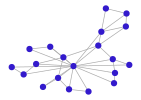

In [164]:
dmPlot(20)

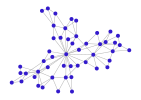

In [13]:
dmPlot(50)

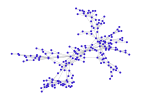

In [14]:
dmPlot(200)

Замечу, что во всех достаточно больших сгенерированных графах (выше лишь несколько примеров) есть вершины с относительно высокой степенью (назовём их `центры`). Похоже, они - естественное следствие работы генератора: чем больше рёбер смежно с вершиной, тем вероятнее, что при следующем шаге генератора, на одну из них выпадет стать смежной новой вершине, а значит, степень такого `центра` снова повысится.

### 2.2 [Erdős–Rényi <base target="_blank">](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model)
Этот алгоритм создаёт `n` вершин и пробрасывает между всеми парами установленную вероятность `p` чтобы соединить их ребром.

Посмотрим на его работу:

In [15]:
erPlot(n, p) = gplot(erdos_renyi(n, p), nodefillc = RGB(0.70,0.7,0.42), edgestrokec = "darkgray")

erPlot (generic function with 1 method)

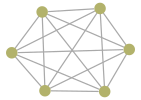

In [16]:
erPlot(6, 1.0)

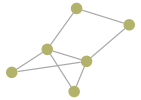

In [17]:
erPlot(6, 0.5)

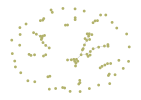

In [161]:
erPlot(100, 0.01)

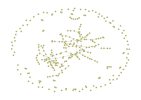

In [123]:
erPlot(300, 0.005)

Видим, что не все сгенерированные графы оказались полносвязными. Именно для этого случая в нашей функции есть фильтрация расстояний между вершинами разных компонент связности.

### 2.3 [Регулярный граф <base target="_blank">](https://en.wikipedia.org/wiki/Regular_graph)

In [20]:
rgPlot(n, d) = gplot(random_regular_graph(n, d), nodefillc = "darkgreen", edgestrokec = "darkgray");

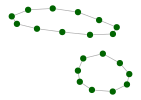

In [122]:
rgPlot(20, 2)

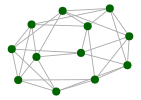

In [121]:
rgPlot(12, 5)

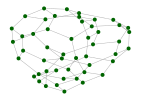

In [23]:
rgPlot(50, 3)

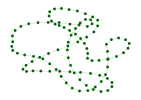

In [106]:
rgPlot(100, 2)

Отдельно хотелось бы посмотреть на 2- и 3-мерные решётки:
### 2.4 Решётки

In [25]:
gridPlot(grid) = gplot(Graphs.grid(grid), nodefillc = RGB(0.75,0.1,0.3), edgestrokec = "darkgray");

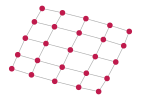

In [26]:
gridPlot([5,5])

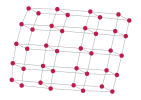

In [93]:
gridPlot([4,2,5])

Я упускаю много ещё разновидностей графов, но не могу обойти стороной деревья.
### 2.5 [Однородные (uniform) деревья  <base target="_blank">](https://en.wikipedia.org/wiki/Uniform_tree)

In [28]:
utPlot(n) = gplot(uniform_tree(n), nodefillc = RGB(0.3,0.85,0.3), edgestrokec = "darkgray");

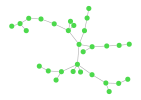

In [83]:
utPlot(30)

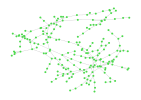

In [81]:
utPlot(200)

### 2.6 Бинарные деревья

In [31]:
btPlot(n) = gplot(binary_tree(n), nodefillc = RGB(0.6,0.7,0.6), edgestrokec = "darkgray");

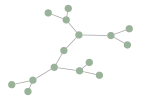

In [32]:
btPlot(4)

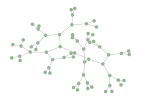

In [33]:
btPlot(6)

---
# 3. Эксперименты!
## 3.1 Dorogovtsev and Mendes

In [34]:
function d_m_tests(nspace, repeats)
    results = Float32[]
    for n in nspace # Количество вершин
        av = 0
        for i = 1:repeats # Количество повторений для усреднения
            g = dorogovtsev_mendes(n) # новый случайный граф на каждом шаге
            av += mean_ratio(g) # поиск всех путей - от каждой до каждой другой
        end
        push!(results, av/repeats)
    end
    return results
end;

In [297]:
function d_m_tests(nspace, repeats)
    results = Float32[]
    for n in nspace # Количество вершин
        av = 0
        for i = 1:repeats # Количество повторений для усреднения
            g = dorogovtsev_mendes(n) # новый случайный граф на каждом шаге
            av += mean_psi_(g) # поиск всех путей - от каждой до каждой другой
        end
        push!(results, av/repeats)
    end
    return results
end;

Сначала будем варьировать количество повторения для усреднения:

In [300]:
nspace = 5:30

dmt1 = d_m_tests(nspace, 10)
dmt2 = d_m_tests(nspace, 25)
dmt3 = d_m_tests(nspace, 50)
dmt4 = d_m_tests(nspace, 100)
dmt5 = d_m_tests(nspace, 200);

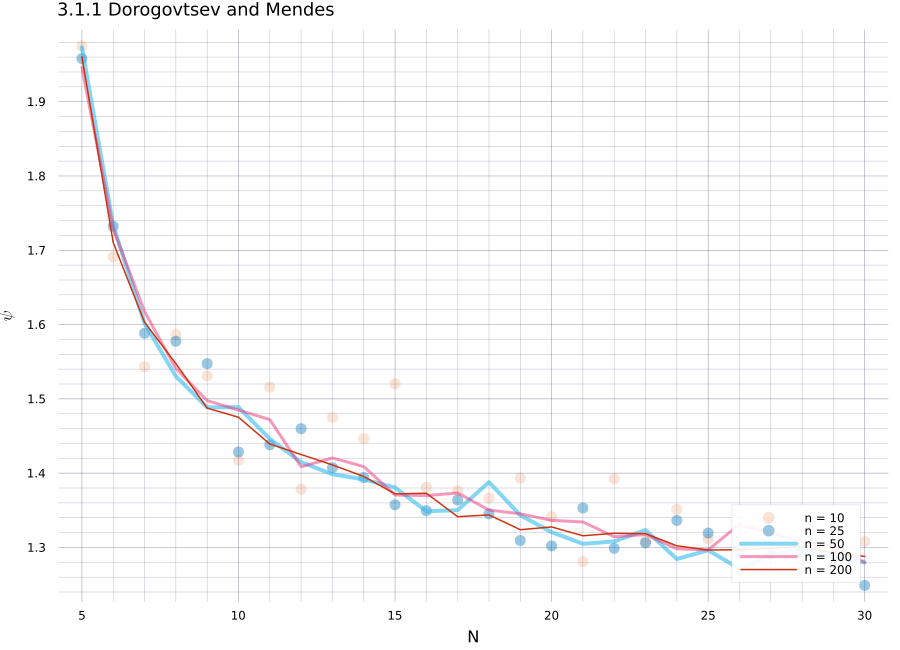

In [301]:
theme(:vibrant)
scatter(nspace, dmt1,
    title = "3.1.1 Dorogovtsev and Mendes",
    titlepos = :left,
    titlefontsize = 12,
    legend = :bottomright,
    label = "n = 10",
    size = (900, 650),
    xaxis = "N",
    yaxis = L"\psi",
    linewidth =8,
    alpha = 0.2,
    
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    )
scatter!(nspace, dmt2, label = "n = 25", linewidth = 6,  alpha = 0.4,)
plot!(nspace,    dmt3, label = "n = 50", linewidth = 4,  alpha = 0.6,)
plot!(nspace,    dmt4, label = "n = 100",linewidth = 3, alpha = 0.5,)
plot!(nspace,    dmt5, label = "n = 200",linewidth = 1.5,alpha = 1,)

In [74]:
savefig("plots/3.1.1.svg");

Далее зададим уже логарифмически убывающую плотность точек по горизонтали. Самые долгие вычисления в этой работе:

In [38]:
logspace = range(0.8, stop=3.1, length=50) .|> exp10 .|> ceil .|> Int;
dmt6 = d_m_tests(logspace, 350);

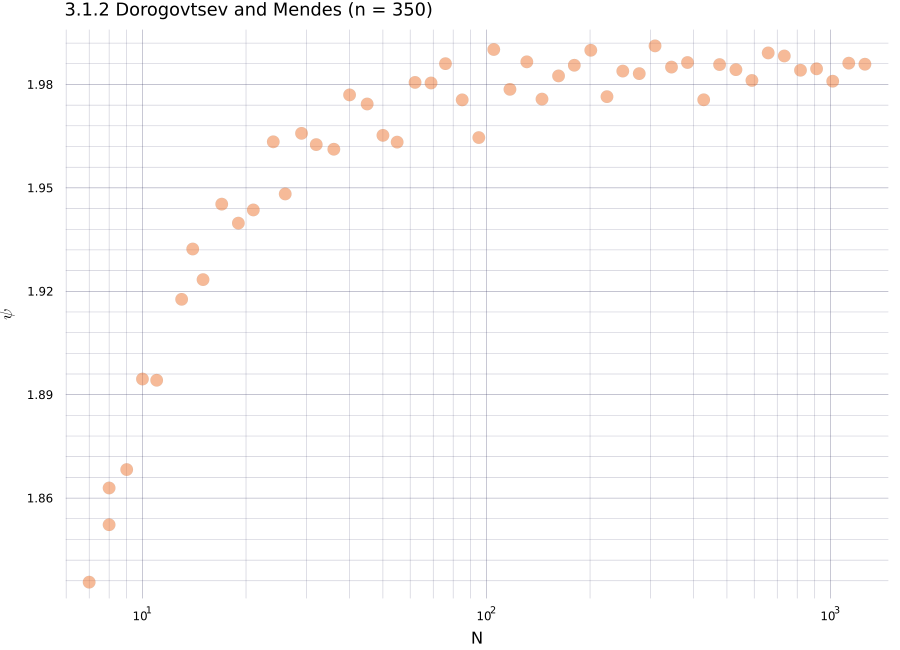

In [39]:
theme(:vibrant)
scatter(logspace, dmt6,
    title = "3.1.2 Dorogovtsev and Mendes (n = 350)",
    titlepos = :left,
    titlefontsize = 12,
    legend = :bottomright,
    label = false,
    size = (900, 650),
    xaxis = ("N", :log),
    yaxis = L"\psi",
    markersize =7,
    alpha = 0.5,
    
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
)

In [40]:
savefig("plots/3.1.2.svg");

### 3.2 Erdős–Rényi

In [41]:
function e_r_tests(nspace, pspace, repeats)
    results = Float32[]
    for n in nspace # Количество вершин
        for p in pspace # Различные вероятности
            av = 0
            for i = 1:repeats # Количество повторений для усреднения
                g = erdos_renyi(n, p) # новый случайный граф на каждом шаге
                av += mean_ratio(g) # поиск всех путей - от каждой до каждой другой
            end
            push!(results, av/repeats)
        end
    end
    return results
end;

В отличие от предыдущего алгоритма, усреднение по нескольким повторам для минимизации шума не требуется.

In [42]:
repeats = 1
nspace = 3:50:1000
ert0 = e_r_tests(nspace, [0.01], repeats)
ert1 = e_r_tests(nspace, [0.05], repeats)
ert2 = e_r_tests(nspace, [0.3], repeats)
ert3 = e_r_tests(nspace, [0.5], repeats)
ert4 = e_r_tests(nspace, [0.7], repeats)
ert5 = e_r_tests(nspace, [1.0], repeats);

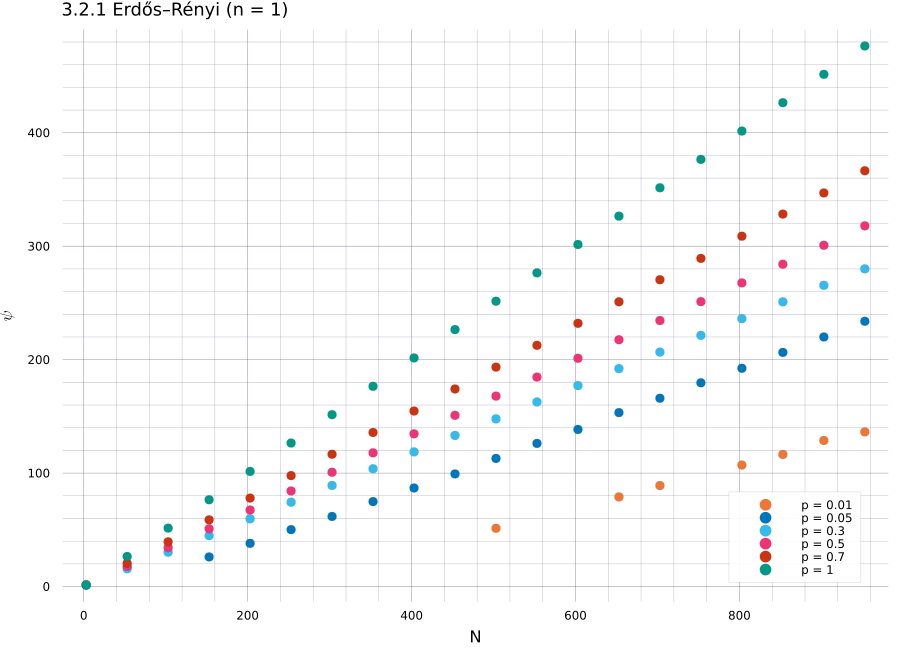

In [43]:
theme(:vibrant)
scatter(nspace, ert0,
    title = "3.2.1 Erdős–Rényi (n = 1)",
    titlepos = :left,
    titlefontsize = 12,
    legend = :bottomright,
    label = "p = 0.01",
    size = (900, 650),
    xaxis = "N",
    yaxis = L"\psi",
    markersize = 5,
    
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    )

scatter!(nspace, ert1, label = "p = 0.05",markersize = 5,)
scatter!(nspace, ert2, label = "p = 0.3",markersize = 5,)
scatter!(nspace, ert3, label = "p = 0.5",markersize = 5,)
scatter!(nspace, ert4, label = "p = 0.7",markersize = 5,)
scatter!(nspace, ert5, label = "p = 1",markersize = 5,)

In [44]:
savefig("plots/3.2.1.svg");

In [45]:
repeats = 1
nspace = [150]
# pspace = range(0.05, stop=1, length=50)
plogspace = range(-1.5, stop=0, length=50) .|> exp10
ert6 = e_r_tests([300], plogspace, repeats)
ert7 = e_r_tests([400], plogspace, repeats)
ert8 = e_r_tests([500], plogspace, repeats);

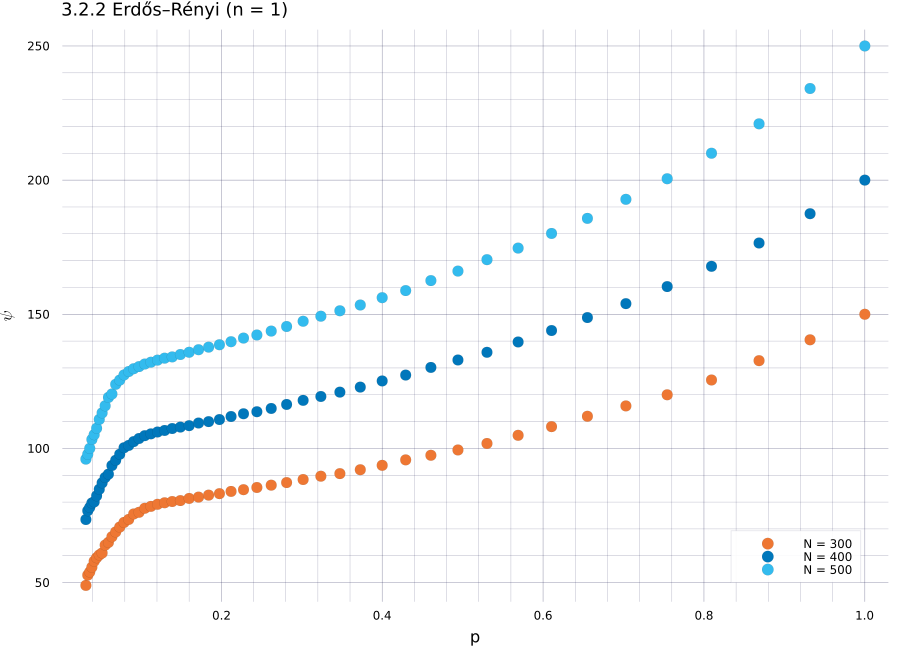

In [68]:
theme(:vibrant)
scatter(plogspace, ert6,
    title = "3.2.2 Erdős–Rényi (n = 1)",
    titlepos = :left,
    titlefontsize = 12,
    legend = :bottomright,
    label = "N = 300",
    size = (900, 650),
    xaxis = "p",
    yaxis = L"\psi",
    linewidth = 4,
    
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    )

scatter!(plogspace, ert7, label = "N = 400",linewidth = 4,)
scatter!(plogspace, ert8, label = "N = 500",linewidth = 4,)

In [69]:
savefig("plots/3.2.2.svg");

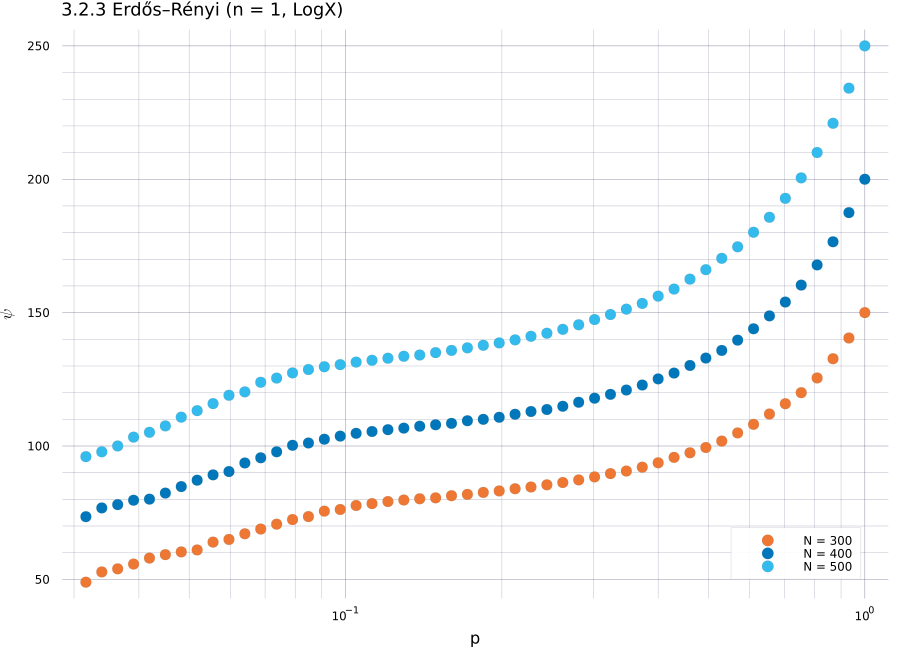

In [67]:
theme(:vibrant)
scatter(plogspace, ert6,
    title = "3.2.3 Erdős–Rényi (n = 1, LogX)",
    titlepos = :left,
    titlefontsize = 12,
    legend = :bottomright,
    label = "N = 300",
    size = (900, 650),
    xaxis = ("p", :log),
    yaxis = L"\psi",
    linewidth = 4,
    
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    )

scatter!(plogspace, ert7, label = "N = 400",linewidth = 4,)
scatter!(plogspace, ert8, label = "N = 500",linewidth = 4,)

In [70]:
savefig("plots/3.2.3.svg");

### 3.3 Регулярный граф

In [50]:
function r_g_tests(nspace, kspace, repeats)
    results = Float32[]
    for n in nspace # Количество вершин
        for k in kspace # Различные степени вершин
            av = 0
            for i = 1:repeats # Количество повторений для усреднения
                g = random_regular_graph(n, k) # новый случайный граф на каждом шаге
                av += mean_ratio(g) # поиск всех путей - от каждой до каждой другой
            end
            push!(results, av/repeats)
        end
    end
    return results
end;

In [302]:
function r_g_tests(nspace, kspace, repeats)
    results = Float32[]
    for n in nspace # Количество вершин
        for k in kspace # Различные степени вершин
            av = 0
            for i = 1:repeats # Количество повторений для усреднения
                g = random_regular_graph(n, k) # новый случайный граф на каждом шаге
                av += mean_psi_(g) # поиск всех путей - от каждой до каждой другой
            end
            push!(results, av/repeats)
        end
    end
    return results
end;

In [303]:
repeats = 10
nspace = 3:2:100
rgt1 = r_g_tests(3:2:300, [2], repeats)
rgt2 = r_g_tests(4:2:300, [3], 2*repeats)
rgt3 = r_g_tests(5:2:300, [4], repeats);

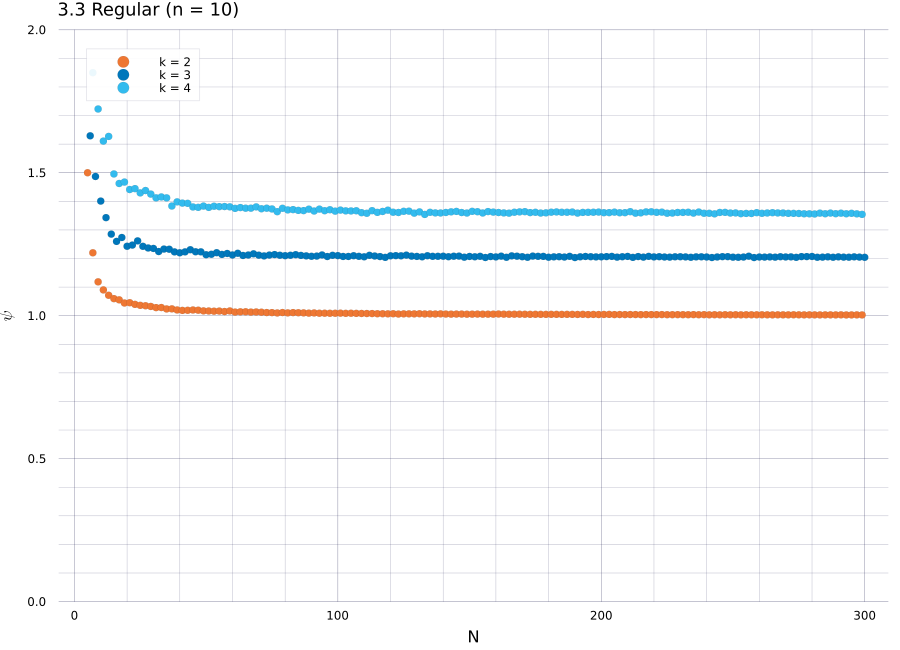

In [307]:
theme(:vibrant)
scatter(3:2:300, rgt1,
    title = "3.3 Regular (n = 10)",
    titlepos = :left,
    titlefontsize = 12,
    legend = :topleft,
    label = "k = 2",
    size = (900, 650),
    xaxis = "N",
    yaxis = L"\psi",
    ylim = (0, 2),
    markersize = 4,
    
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    )

scatter!(4:2:300, rgt2, label = "k = 3",markersize = 4,)
scatter!(5:2:300, rgt3, label = "k = 4",markersize = 4,)

In [53]:
savefig("plots/3.3.svg");

### 3.4 Решётки

In [54]:
function grid_tests(nspace, dimspace, repeats)
    results = Float32[]
    for n in nspace # Количество вершин
        for d in dimspace
            griddims = fill(n, d)
            av = 0
            for i = 1:repeats # Количество повторений для усреднения
                g = Graphs.grid(griddims) # новый случайный граф на каждом шаге
                av += mean_ratio(g) # поиск всех путей - от каждой до каждой другой
            end
            push!(results, av/repeats)
        end
    end
    return results
end;

In [308]:
function grid_tests(nspace, dimspace, repeats)
    results = Float32[]
    for n in nspace # Количество вершин
        for d in dimspace
            griddims = fill(n, d)
            av = 0
            for i = 1:repeats # Количество повторений для усреднения
                g = Graphs.grid(griddims) # новый случайный граф на каждом шаге
                av += mean_psi_(g) # поиск всех путей - от каждой до каждой другой
            end
            push!(results, av/repeats)
        end
    end
    return results
end;

In [309]:
repeats = 1

gt1 = grid_tests(3:25, [2], repeats);
gt2 = grid_tests(3:13, [3], repeats);

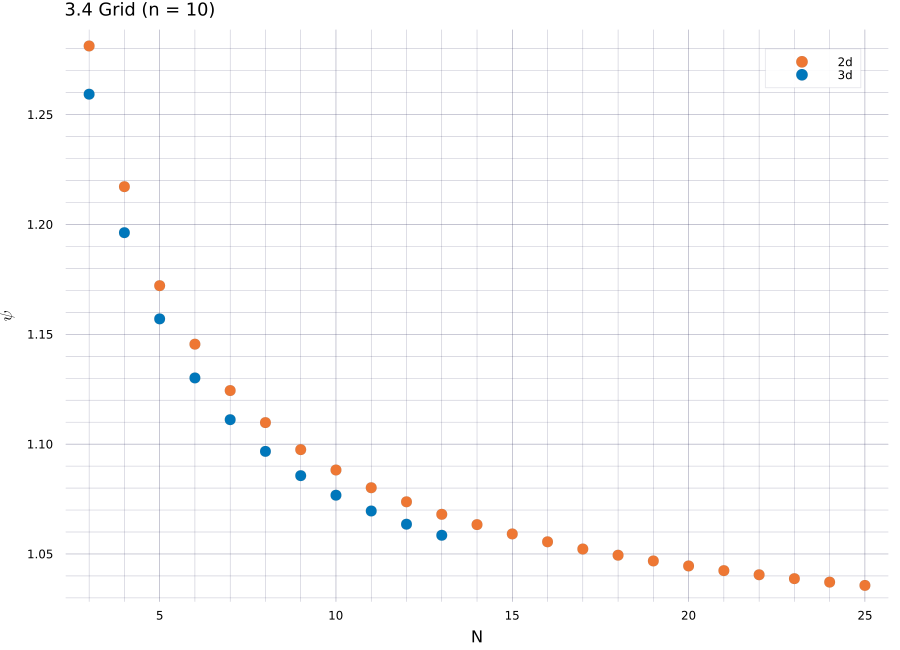

In [310]:
theme(:vibrant)
scatter(3:25, gt1,
    title = "3.4 Grid (n = 10)",
    titlepos = :left,
    titlefontsize = 12,
    legend = :topright,
    label = "2d",
    size = (900, 650),
    xaxis = "N",
    yaxis = L"\psi",
    linewidth = 4,
    
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    )

scatter!(3:13, gt2, label = "3d",linewidth = 4,)

In [63]:
savefig("plots/3.4.svg");

### 3.5-3.6 Деревья

In [58]:
function t_tests(nspace, repeats, tree)
    results = Float32[]
    for n in nspace # Количество вершин
        av = 0
        for i = 1:repeats # Количество повторений для усреднения
            g = tree(n) # новый случайный граф на каждом шаге
            av += mean_ratio(g) # поиск всех путей - от каждой до каждой другой
        end
        push!(results, av/repeats)
    end
    return results
end;

In [59]:
repeats = 1
nspace = 1:12

t1 = t_tests(3:20:1024, 1, uniform_tree);
t2 = t_tests(2:10, 1, binary_tree);

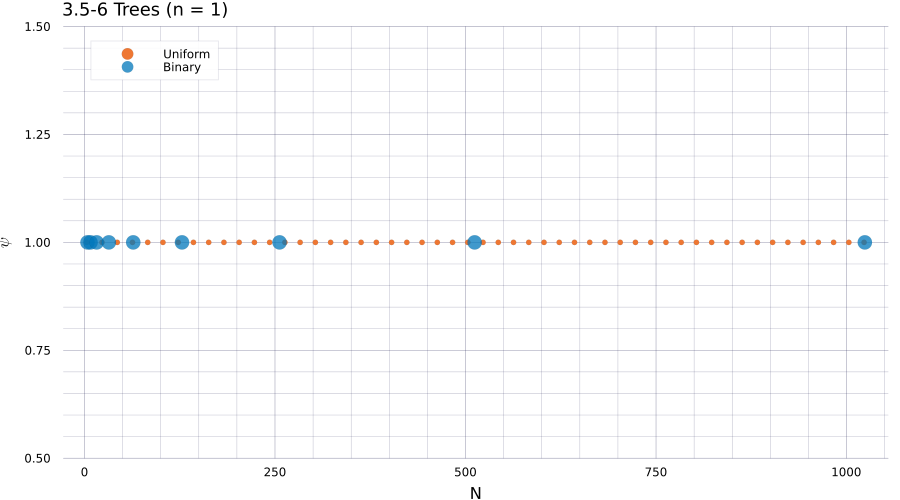

In [60]:
theme(:vibrant)
scatter(3:20:1024, t1,
    title = "3.5-6 Trees (n = 1)",
    titlepos = :left,
    titlefontsize = 12,
    legend = :topleft,
    label = "Uniform",
    size = (900, 500),
    xaxis = "N",
    ylim = (0.5,1.5),
    yaxis = L"\psi",
    markersize = 3,
    alpha = 1,
    
    minorgrid = true,
    minorgridalpha = 0.3,
    gridalpha = 0.5,
    )

scatter!(2 .^[2:10;], t2, label = "Binary", markersize = 8, alpha = 0.75)

In [61]:
savefig("plots/3.5-6.svg");

---
# 4. Заключение
Не с первого раза получилось сделать всё правильно и даже теперь нельзя исключать ошибок и неточностей. Предложенная гипотеза о том, что поиск в ширину вдвое эффективнее поиска в глубину для неорентированных графов действительно имеет основания, но, как можно видеть из примеров, выполняется далеко не для всех графов, а для остальных является, похоже, предельным случаем. Итого имеем:
* Метод Дороговцева Мендеса — $\Large\psi$ приближается к 2 начиная со 100 вершин.
* Модель Модель Эрдёша-Реньи — гипотеза не выполняется
* Регулярные графы — гипотеза подтвердилась при степени вершин $k=2$
* 2- и 3-мерные решётки - гипотеза не выполняется
* Однородные и бинарные деревья - гипотеза не выполняется (примечание: оба алгоритма поиска в среднем показывают себя одинаково при любом количестве вершин)